In [1]:
import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

In [2]:
spark

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
from io import BytesIO
import re
import matplotlib.pyplot as plt
# import tensorflow as tf
# import cv2

# Big Data

## Spark Connection

I will use the functionality of Image Datasource of spark to collect and process images in bytes, and then start processing the images for the neural network

In [4]:
# '/CA1/Images/BakedPotato/',
images_folders = ['/CA1/Images/Pizza/','/CA1/Images/Taco/','/CA1/Images/HotDog/']

In [5]:
images_rdd = spark.sparkContext.binaryFiles(','.join(images_folders))
# images_rdd = spark.sparkContext.binaryFiles('hdfs://172.24.144.178:9000/CA1/Images/Ireland/Ireland_001.jpeg')

In [6]:
images_rdd

org.apache.spark.api.java.JavaPairRDD@7f64dbe2

In [7]:
def extract_data(data):
    file_path, image_data = data
#     image = Image.open(BytesIO(image_data))
#     image_array = np.array(image)
    
    file_name = file_path.split('/')[-1]
    file_name_without_ext = file_name.split(".")[0]
    label,name = file_name_without_ext.split('_')[0], file_name_without_ext.split('_')[1]
    
    return name, label, image_data

In [8]:
imageDf = images_rdd.map(lambda x: extract_data(x)).toDF(["Name","Label","Data"])

In [9]:
pandasImagesDF = imageDf.toPandas()

## Image Preprocessing 

In [10]:
IMG_SHAPE=225

In [11]:
def processImage(data, target_size=(IMG_SHAPE,IMG_SHAPE)):
    imgbytes = BytesIO(data)
    image = Image.open(imgbytes)
    resized_img = image.resize(target_size, Image.ANTIALIAS)
    with BytesIO() as output:
        resized_img.save(output, format="PNG")
        new_image = Image.open(output)

        array = np.asarray(new_image).reshape([target_size[0],target_size[1],3])
        return array

In [12]:
pandasImagesDF["Data"] = pandasImagesDF["Data"].apply(lambda x: processImage(x))

In [13]:
# pandasImagesDF

In [14]:
pandasImagesDF = pandasImagesDF.sort_values(by=["Name"])

In [15]:
pandasImagesDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, 0 to 899
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    900 non-null    object
 1   Label   900 non-null    object
 2   Data    900 non-null    object
dtypes: object(3)
memory usage: 28.1+ KB


In [16]:
NCATEGORIES = len(pandasImagesDF["Label"].unique())

In [17]:
NCATEGORIES

3

# Neural Networks

## Bare Model

Importing from Keras functionality necessary to implement CNN

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, Input, MaxPool2D
from tensorflow.keras import utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import RandomContrast, RandomBrightness, RandomRotation, RandomFlip, GaussianNoise, RandomZoom

2024-03-28 22:21:39.844060: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 22:21:40.952460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.experimental.set_virtual_device_configuration(gpu,[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])


2024-03-28 22:21:42.709696: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 22:21:42.956828: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 22:21:42.956881: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Now we are to split the data using train_test_split function to use Kfold and improve the perfomance of the model

In [20]:
X_train, X_test, y_train, y_test = train_test_split(pandasImagesDF["Data"],pandasImagesDF["Label"],test_size=0.20, random_state=32)

In [21]:
y_train

316      Taco
287     Pizza
502      Taco
584      Taco
324      Taco
        ...  
329      Taco
597      Taco
104     Pizza
784    HotDog
542      Taco
Name: Label, Length: 720, dtype: object

In [22]:
encoder = OneHotEncoder(sparse_output=False)
y_train = np.array(y_train).reshape(-1, 1)
y_train = encoder.fit_transform(y_train)

y_test = np.array(y_test).reshape(-1,1)
y_test = encoder.fit_transform(y_test)

In [23]:
X_train = np.stack(X_train)
X_test = np.stack(X_test)

In [24]:
X_train.shape

(720, 225, 225, 3)

In [25]:
X_train = np.reshape(X_train,(X_train.shape[0],IMG_SHAPE,IMG_SHAPE,3)).astype(np.float32)
X_test = np.reshape(X_test,(X_test.shape[0],IMG_SHAPE,IMG_SHAPE,3)).astype(np.float32)

Because the pixels are from 0 to 255, We have to normalize the pixels

In [26]:
X_train/=255
X_test/=255

In [27]:
X_train.shape,X_test.shape

((720, 225, 225, 3), (180, 225, 225, 3))

In [28]:
y_train.shape, y_test.shape

((720, 3), (180, 3))

In [70]:
model = Sequential(name="BareCNN")
model.add(Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)))  # 225x225 RGB images
model.add(Conv2D(32,kernel_size=(3,3),strides=(1,1),padding="valid", activation="relu"))
model.add(Conv2D(32,kernel_size=(3,3),activation="relu"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation="relu"))
model.add(Conv2D(64,kernel_size=(3,3),activation="relu"))
model.add(MaxPool2D(3))

model.add(Flatten())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.50))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.50))
model.add(Dense(NCATEGORIES,activation="softmax"))

model.compile(loss=tf.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=tf.optimizers.Adam(learning_rate=0.0001))
model.summary()

Model: "BareCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 223, 223, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 221, 221, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 78400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │    10,035,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,117,795 (38.60 MB)

 Trainable params: 10,117,795 (38.60 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
history = model.fit(X_train, y_train, batch_size=20, epochs=20, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5699 - loss: 0.8920 - val_accuracy: 0.5111 - val_loss: 0.9588
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5765 - loss: 0.8763 - val_accuracy: 0.5278 - val_loss: 0.9581
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5947 - loss: 0.8637 - val_accuracy: 0.5333 - val_loss: 0.9333
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.6725 - loss: 0.7714 - val_accuracy: 0.5556 - val_loss: 0.9213
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7106 - loss: 0.7037 - val_accuracy: 0.5611 - val_loss: 0.9527
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.6948 - loss: 0.7211 - val_accuracy: 0.5556 - val_loss: 0.9420
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7209 - loss: 0.6969 - val_accuracy: 0.5500 - val_loss: 0.9297
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7175 - loss: 0.6500 - val_accuracy: 0.5278 - v

6/6 - 1s - 185ms/step - accuracy: 0.5278 - loss: 0.9771


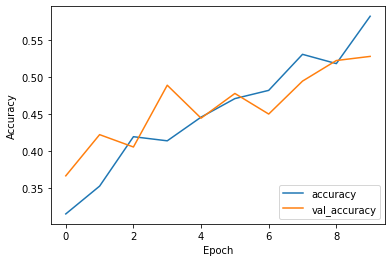

In [72]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

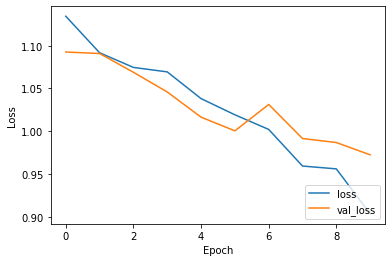

In [73]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [74]:
print(test_acc)

0.5277777910232544


## Data Augmentation 

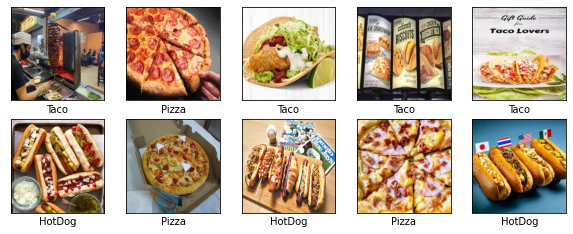

In [39]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(X_train[i])
    plt.xlabel(encoder.inverse_transform([y_train[i]])[0][0])

In [40]:
dataAugmented = Sequential()
# dataAugmented.add(RandomContrast(factor=(0.2)))
# dataAugmented.add(RandomBrightness(factor=0.005))
dataAugmented.add(RandomRotation(factor=(-0.5,0.8)))
dataAugmented.add(RandomFlip("horizontal_and_vertical"))
# dataAugmented.add(GaussianNoise(0.8))
# dataAugmented.add(RandomZoom((0.2,0.3)))


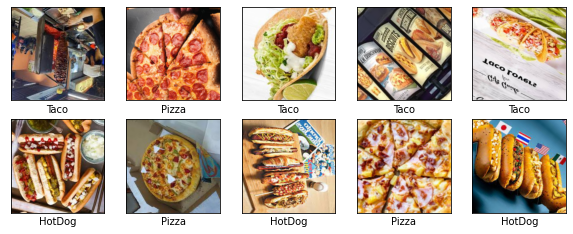

In [41]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    newIMG = dataAugmented(np.array([X_train[i]]))
    plt.imshow((newIMG[0].numpy()*255).astype(np.uint8))
    plt.xlabel(encoder.inverse_transform([y_train[i]])[0][0])
plt.show()

In [56]:
modelAugmented = Sequential()
modelAugmented.add(Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)))  # 225x225 RGB images
modelAugmented.add(dataAugmented)
modelAugmented.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"))
modelAugmented.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))
modelAugmented.add(MaxPool2D(3))

modelAugmented.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"))
modelAugmented.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))
modelAugmented.add(MaxPool2D(3))

modelAugmented.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"))
modelAugmented.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),padding="same",activation="relu"))
modelAugmented.add(MaxPool2D(3))

modelAugmented.add(Flatten())
modelAugmented.add(Dense(256, activation="relu"))
modelAugmented.add(Dropout(0.50))
modelAugmented.add(Dense(256, activation="relu"))
modelAugmented.add(Dropout(0.50))
modelAugmented.add(Dense(NCATEGORIES,activation="softmax"))

modelAugmented.compile(loss=tf.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=tf.optimizers.Adam(learning_rate=0.0002))
modelAugmented.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 225, 225, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 225, 225, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,301,827 (4.97 MB)

 Trainable params: 1,301,827 (4.97 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((720, 225, 225, 3), (180, 225, 225, 3), (720, 3), (180, 3))

In [58]:
history = modelAugmented.fit(X_train, y_train, batch_size=20, epochs=50, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.3273 - loss: 1.0986 - val_accuracy: 0.3889 - val_loss: 1.0911
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.3902 - loss: 1.0819 - val_accuracy: 0.3889 - val_loss: 1.0495
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.4890 - loss: 0.9917 - val_accuracy: 0.4611 - val_loss: 1.0521
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.5207 - loss: 0.9834 - val_accuracy: 0.4278 - val_loss: 1.0198
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.5291 - loss: 0.9534 - val_accuracy: 0.5333 - val_loss: 0.9877
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.5811 - loss: 0.9178 - val_accuracy: 0.4556 - val_loss: 1.0268
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.5406 - loss: 0.9242 - val_accuracy: 0.4167 - val_loss: 1.0716
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.6178 - loss: 0.8931 - val_accuracy: 0.

6/6 - 1s - 143ms/step - accuracy: 0.8056 - loss: 0.5383


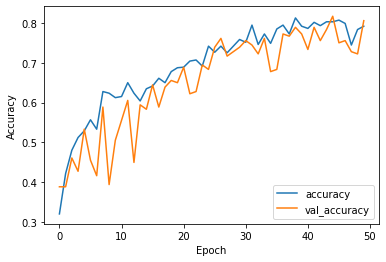

In [59]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelAugmented.evaluate(X_test,  y_test, verbose=2)

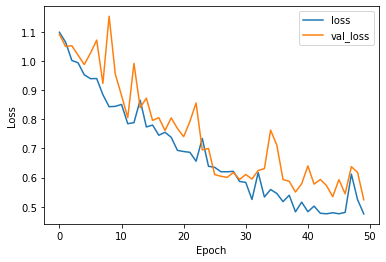

In [60]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='upper right')


In [61]:
print(test_acc)

0.8055555820465088


## Pre-trained Model 

In [62]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [63]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(225, 225, 3))

In [64]:
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom classifier on top
x = Flatten()(vgg_base.output)
x = Dense(256, activation='relu')(x)
output = Dense(NCATEGORIES, activation='softmax')(x)

In [65]:
modelVGG = Model(inputs=vgg_base.input, outputs=output)
modelVGG.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
modelVGG.summary()

Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 225, 225, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 225, 225, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [66]:
history = modelVGG.fit(X_train, y_train, batch_size=12, epochs=5, verbose=1, validation_data=(X_test, y_test))

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.4912 - loss: 4.0083 - val_accuracy: 0.8167 - val_loss: 0.4389
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9560 - loss: 0.1393 - val_accuracy: 0.8111 - val_loss: 0.5926
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9911 - loss: 0.0471 - val_accuracy: 0.8389 - val_loss: 0.4818
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 1.0000 - loss: 0.0159 - val_accuracy: 0.8444 - val_loss: 0.5067
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.8389 - val_loss: 0.5052


6/6 - 1s - 205ms/step - accuracy: 0.8389 - loss: 0.4902


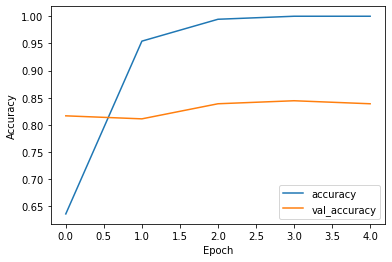

In [67]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelVGG.evaluate(X_test,  y_test, verbose=2)

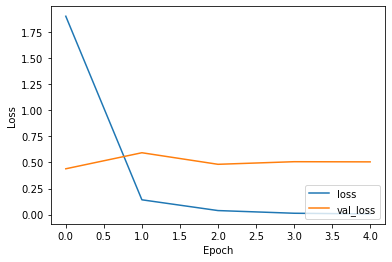

In [68]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [69]:
print(test_acc)

0.8388888835906982
